In [1]:
import numpy as np
import json
import io
import os
import sys
import pickle
import math

from pymoo.core.problem import ElementwiseProblem
from non_iid_generator.customDataset import CustomDataset

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.soo.nonconvex.ga import GA

from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize

import matplotlib.pyplot as plt

In [2]:
NO_CLIENTS = 140
NO_GROUPS = 10
NO_CLASSES = 10

In [3]:
conf = json.loads(open("data/Cifar10_NIID_a05_140c/config.json", "r").read())
data = [dict(zip(np.array(cli)[:,0], np.array(cli)[:,1])) for cli in conf["Size of samples for labels in clients"]]

main_label_vectors = np.zeros((NO_CLIENTS,NO_CLASSES))
for client_id in range(NO_CLIENTS):
    for class_id in range(NO_CLASSES):
        if class_id in data[client_id].keys():
            main_label_vectors[client_id][class_id] = data[client_id][class_id]
main_label_vectors

array([[  0.,   0.,   0., ..., 381.,   0.,   0.],
       [  0., 231.,   0., ...,   0.,   0.,   0.],
       [  0.,  46.,   0., ...,   0.,   0.,  13.],
       ...,
       [ 40.,  39.,   0., ...,   0.,   0.,  52.],
       [  0.,   0.,   0., ...,   2.,   0.,   0.],
       [202.,   1., 117., ...,   1.,   1.,  27.]])

In [23]:
def EMD(Z_i, Z_global):
    magnitude = lambda vector: math.sqrt(sum(pow(element, 2) for element in vector))
    return magnitude(Z_i/magnitude(Z_i) - Z_global/magnitude(Z_global))

def group_distribution(label_vectors, groups):
    group_dist = []
    for gid in range(NO_GROUPS):
        group_vector = label_vectors[groups == gid]
        group_dist.append(np.sum(group_vector, axis = 0))
    return group_dist

def group_max_size(label_vectors, groups):
    group_max = []
    for gid in range(NO_GROUPS):
        group_vector = label_vectors[groups == gid]
        group_max.append(np.amax(np.sum(group_vector, axis = 1)))
    return group_max

def emd_obj(group_dist):
    Z_global = np.sum(group_dist, axis = 0)
    return np.sum([EMD(group, Z_global) for group in group_dist])
        

groups = np.repeat(np.arange(10),14)
np.random.shuffle(groups)

group_dist = group_distribution(main_label_vectors, groups)
emd_obj(group_dist)

6.754564654202862

In [35]:
group_max = group_max_size(main_label_vectors, groups)
dif = np.amax(group_max) - np.amin(group_max)
dif

2077.0

In [84]:
import random

class MyProblem(ElementwiseProblem):

    def __init__(self, main_label_vectors):
        super().__init__(n_var=NO_CLIENTS,
                         n_obj=2,
                        #  n_eq_constr=NO_CLASSES,
                         n_ieq_constr=NO_CLASSES,
                         xl=np.ones(NO_CLIENTS) * 0,
                         xu=np.ones(NO_CLIENTS) * 10,
                         vtype=int)
        self.main_label_vectors = main_label_vectors

    def _evaluate(self, x, out, *args, **kwargs):
        group_dist = group_distribution(self.main_label_vectors, x)
        f1 = emd_obj(group_dist)
        # f2 = random.randint(0, 5)

        try:
            group_max = group_max_size(self.main_label_vectors, x)
            dif = np.amax(group_max) - np.amin(group_max)
            f2 = dif
        except:
            f2 = 0

        # print(f1)
        # f1 = 100 * (x[0]**2 + x[1]**2)
        # f2 = (x[0]-1)**2 + x[1]**2
        # print(np.unique(x, return_counts=True)[1] - 14)

        similarity = 12
        hs = (np.unique(x, return_counts=True)[1] - similarity).tolist()
        if len(hs) != NO_CLASSES: hs = np.zeros(NO_CLASSES) - 14

        gs = (similarity - np.unique(x, return_counts=True)[1]).tolist()
        if len(gs) != NO_CLASSES: gs = 14 - np.zeros(NO_CLASSES)
                



        # print(np.unique(x, return_counts=True)[1] - 14)
        # g1 = 2*(x[0]-0.1) * (x[0]-0.9) / 0.18
        # g2 = - 20*(x[0]-0.4) * (x[0]-0.6) / 4.8

        out["F"] = [f1, f2]
        # out["H"] = hs
        out["G"] = gs

In [85]:
problem = MyProblem(
    main_label_vectors = main_label_vectors
)

algorithm = NSGA2(
    pop_size=40,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.1, eta=1, vtype=int),
    mutation=PM(eta=1, vtype=int),
    eliminate_duplicates=True
)

termination = get_termination("n_gen", 1000)

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

X = res.X
F = res.F

/tmp/ipykernel_12135/1381933869.py:3: RuntimeWarning: divide by zero encountered in divide
  return magnitude(Z_i/magnitude(Z_i) - Z_global/magnitude(Z_global))
/tmp/ipykernel_12135/1381933869.py:3: RuntimeWarning: invalid value encountered in divide
  return magnitude(Z_i/magnitude(Z_i) - Z_global/magnitude(Z_global))


n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       40 |      1 |  1.400000E+02 |  1.400000E+02 |             - |             -
     2 |       50 |      1 |  3.0000000000 |  1.063250E+02 |             - |             -
     3 |       60 |      1 |  3.0000000000 |  7.310000E+01 |             - |             -
     4 |       70 |      1 |  3.0000000000 |  3.992500E+01 |             - |             -
     5 |       80 |      1 |  3.0000000000 |  6.2000000000 |             - |             -
     6 |       90 |      1 |  2.0000000000 |  4.6750000000 |             - |             -
     7 |      100 |      1 |  2.0000000000 |  4.1500000000 |             - |             -
     8 |      110 |      1 |  1.0000000000 |  3.6000000000 |             - |             -
     9 |      120 |      1 |  1.0000000000 |  3.3000000000 |             - |             -
    10 |      130 |      1 |  1.0000000000 |  3.0250000000 |             - |             -

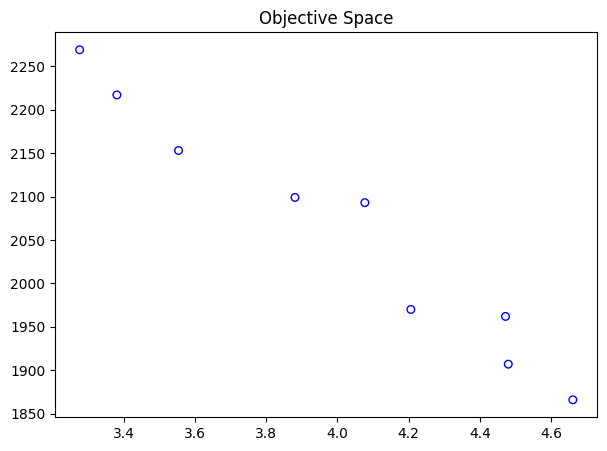

In [86]:
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.show()

In [87]:
X[0]

array([4, 9, 3, 8, 0, 4, 0, 1, 6, 4, 3, 6, 2, 9, 3, 7, 5, 5, 1, 2, 8, 9,
       5, 6, 9, 8, 2, 1, 1, 8, 1, 0, 6, 3, 7, 0, 6, 3, 6, 7, 1, 7, 8, 9,
       0, 4, 9, 6, 2, 1, 3, 5, 0, 2, 7, 3, 5, 1, 8, 6, 1, 4, 6, 2, 0, 7,
       3, 5, 2, 0, 9, 1, 0, 8, 4, 0, 9, 3, 7, 5, 3, 3, 0, 8, 0, 2, 5, 9,
       6, 5, 1, 8, 4, 6, 4, 2, 9, 0, 0, 5, 3, 4, 6, 2, 9, 7, 4, 8, 6, 8,
       4, 1, 8, 5, 0, 7, 7, 8, 7, 3, 3, 0, 0, 2, 4, 5, 2, 2, 0, 9, 6, 9,
       7, 0, 8, 2, 8, 3, 1, 7])

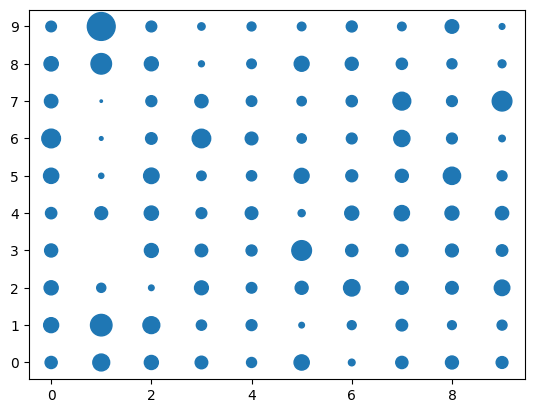

In [88]:
if len(X) < 14: X_sel = X[0]
else: X_sel = X

class_dist = np.asarray(group_distribution(main_label_vectors, X_sel))

x = np.array(np.meshgrid(np.arange(len(np.unique(X_sel))),np.arange(NO_CLASSES))).T.reshape(-1,2)[:,0]
y = np.array(np.meshgrid(np.arange(len(np.unique(X_sel))),np.arange(NO_CLASSES))).T.reshape(-1,2)[:,1]
s = class_dist.reshape(1,-1)[0]
s = ((s - np.amin(s))/(np.amax(s) - np.amin(s))*400).astype("int")

plt.scatter(x,y,s)
plt.yticks(np.arange(10))
plt.show()

In [89]:
np.unique(X_sel, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([19, 13, 14, 15, 12, 12, 14, 13, 15, 13]))

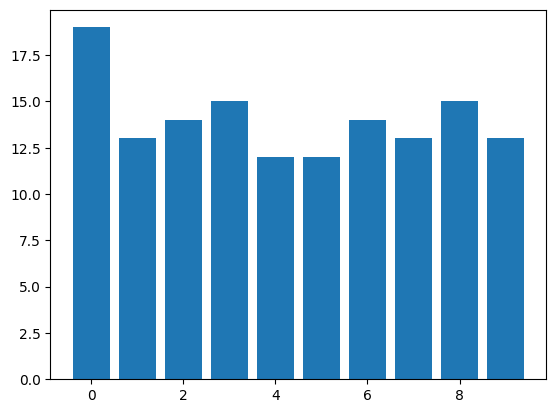

In [90]:
h = np.unique(X[0], return_counts=True)[1]
plt.bar(np.arange(len(h)), h)
plt.show()

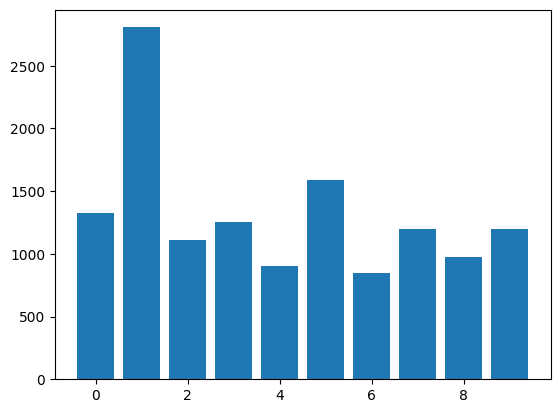

In [91]:
h = np.asarray(group_max_size(main_label_vectors, X[0]))
plt.bar(np.arange(len(h)), h)
# plt.ylim(5900,6000)
plt.show()